# Models comparison

**Objective:** compare logistic regression model and random forest model.

## Library importation

In [1]:
library(ROCR)
library(randomForest)
library(pls)
library(ggplot2)

Loading required package: gplots


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'pls'


The following object is masked from 'package:stats':

    loadings



Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin




## Data loading

In [2]:
ican <- read.csv("simulated_ican_clinical_data.csv", sep = "#", encoding = "utf8")
dim(ican)
set.seed(123)

[1] 2505   28

In [3]:
ican["adjusted_size_ratio"] <- as.factor(ifelse(is.na(ican$adjusted_size_ratio), NA, 
                                                ifelse(ican$adjusted_size_ratio < 3, "<3", 
                                                       ifelse(ican$adjusted_size_ratio >= 3, ">=3", "Other"))))

In [4]:
ican["age"] <- as.factor(ifelse(is.na(ican$age), NA, 
                                ifelse(ican$age < 50, "<50", 
                                       ifelse(ican$age < 60, "50-59", 
                                              ifelse(ican$age < 70, "60-69", 
                                                     ifelse(ican$age >= 70, ">=70", "Other"))))))

In [5]:
ican_LR <- ican
ican_RF <- ican

In [6]:
ican["bmi"] <- as.factor(ifelse(is.na(ican$bmi), NA, 
                                ifelse(ican$bmi < 20, "<20", 
                                       ifelse(ican$bmi < 25, "20-25", 
                                              ifelse(ican$bmi < 30, "25-30", 
                                                     ifelse(ican$bmi >= 30, ">=30", "Other"))))))

## Train / Test

In [7]:
cut <- cvsegments(N = nrow(ican), k = 10)

## Multivariables Logistic Regression

In [8]:
val_auc_LR <- 1:10
x_values_roc_LR <- matrix(nrow = 10, ncol = 252)
y_values_roc_LR <- matrix(nrow = 10, ncol = 252)
sensitivity_LR <- 1:10
specificity_LR <- 1:10
accuracy_LR <- 1:10
val_youden_LR <- 1:10
TP_val_LR <- 1:10
TN_val_LR <- 1:10
FP_val_LR <- 1:10
FN_val_LR <- 1:10
for (i in 1:10) {
    train_LR <- ican_LR[-cut[[i]],]
    test_LR <- ican_LR[cut[[i]],]
    fit_LR <- glm(rupture ~ sex + age + tobacco + hta + IA_location + adjusted_size_ratio + multiple_IA + headaches 
                              + statin_ttt + platelet_aggregation_inhibiting_ttt + hormone_therapy_ttt + allergy, 
                  data = train_LR, family = "binomial") 
    
    pred_valid_LR <- predict(fit_LR, newdata = test_LR, type = "response")
    pr_valid_LR <- prediction(pred_valid_LR, test_LR$rupture) 
    roc_valid_LR <- performance(pr_valid_LR, measure = "tpr", x.measure = "fpr")
    test_x_LR <- as.vector(roc_valid_LR@x.values[[1]])
    test_y_LR <- as.vector(roc_valid_LR@y.values[[1]])
    while (length(test_x_LR) < 252) {
        test_x_LR[length(test_x_LR) + 1] <- 1
        test_y_LR[length(test_y_LR) + 1] <- 1
    }
    x_values_roc_LR[i, ] <- test_x_LR
    y_values_roc_LR[i, ] <- test_y_LR
    
    ind_youden <- pr_valid_LR@tp[[1]]/(pr_valid_LR@tp[[1]] + pr_valid_LR@fn[[1]]) 
                    + pr_valid_LR@tn[[1]]/(pr_valid_LR@tn[[1]] + pr_valid_LR@fp[[1]]) - 1
    val_youden_LR[i] <- pr_valid_LR@cutoffs[[1]][which(ind_youden == max(ind_youden))[1]]
    
    cm <- table(test_LR$rupture, pred_valid_LR > val_youden_LR[i])
    
    TP <- cm["Yes","TRUE"]
    TN <- cm["No","FALSE"]
    FP <- cm["No","TRUE"]
    FN <- cm["Yes","FALSE"]
    
    TP_val_LR[i] <- TP
    TN_val_LR[i] <- TN
    FP_val_LR[i] <- FP
    FN_val_LR[i] <- FN
    
    sensitivity_LR[i] <- TP / (TP + FN)
    specificity_LR[i] <- TN / (TN + FP)
    accuracy_LR[i] <- (TP + TN) / (TP + TN + FP + FN)
    
    prediction.obj_LR <- prediction(pred_valid_LR, test_LR$rupture)
    perf_LR <- performance(prediction.obj_LR, measure = "auc")
    val_auc_LR[i] <- round(perf_LR@y.values[[1]], 2)
}

In [9]:
print("Youden index cutoff")
print(paste("Mean Cutoff =", round(mean(val_youden_LR), 3)))
print(paste("Sensitivity =", round(mean(sensitivity_LR), 3)))
print(paste("Specificity =", round(mean(specificity_LR), 3)))
print(paste0("Accuracy = ", round(mean(accuracy_LR), 3), " [", 
             round(round(mean(accuracy_LR), 3)- 1.96*round(sd(accuracy_LR), 3)/sqrt(10),3),
             ";", round(round(mean(accuracy_LR), 3)+1.96*round(sd(accuracy_LR), 3)/sqrt(10),3), "]"))
print(paste0("AUC = ", round(mean(val_auc_LR), 3), " [", 
             round(round(mean(val_auc_LR), 3)- 1.96*round(sd(val_auc_LR), 3)/sqrt(10),3),
             ";", round(round(mean(val_auc_LR), 3)+1.96*round(sd(val_auc_LR), 3)/sqrt(10),3), "]"))

[1] "Youden index cutoff"
[1] "Mean Cutoff = 0.099"
[1] "Sensitivity = 0.989"
[1] "Specificity = 0.05"
[1] "Accuracy = 0.41 [0.388;0.432]"
[1] "AUC = 0.692 [0.675;0.709]"


In [10]:
print(paste("TP =", mean(TP_val_LR)))
print(paste("TN =", mean(TN_val_LR)))
print(paste("FP =", mean(FP_val_LR)))
print(paste("FN =", mean(FN_val_LR)))

[1] "TP = 94.9"
[1] "TN = 7.9"
[1] "FP = 146.7"
[1] "FN = 1"


## Random Forest

In [11]:
val_auc_RF <- 1:10
x_values_roc_RF <- matrix(nrow = 10, ncol = 252)
y_values_roc_RF <- matrix(nrow = 10, ncol = 252)
sensitivity_RF <- 1:10
specificity_RF <- 1:10
accuracy_RF <- 1:10
val_youden_RF <- 1:10
TP_val_RF <- 1:10
TN_val_RF <- 1:10
FP_val_RF <- 1:10
FN_val_RF <- 1:10
for (i in 1:10) {
    train_RF <- ican_RF[-cut[[i]],]
    test_RF <- ican_RF[cut[[i]],]

    fit_RF <- randomForest(rupture ~ ., data = train_RF, ntree = 600, mtry = 6, importance = TRUE, 
                           nodesize = 1, maxnodes = 130)
    pred_valid_RF <- as.vector(predict(fit_RF, newdata = test_RF, type = "prob")[,2])
    pr_valid_RF <- prediction(pred_valid_RF, test_RF$rupture) 
    roc_valid_RF <- performance(pr_valid_RF, measure = "tpr", x.measure = "fpr")
    test_x_RF <- as.vector(roc_valid_RF@x.values[[1]])
    test_y_RF <- as.vector(roc_valid_RF@y.values[[1]])
    while (length(test_x_RF) < 252) {
        test_x_RF[length(test_x_RF) + 1] <- 1
        test_y_RF[length(test_y_RF) + 1] <- 1
    }
    x_values_roc_RF[i, ] <- test_x_RF
    y_values_roc_RF[i, ] <- test_y_RF
    
    ind_youden <- pr_valid_RF@tp[[1]]/(pr_valid_RF@tp[[1]] + pr_valid_RF@fn[[1]]) 
                    + pr_valid_RF@tn[[1]]/(pr_valid_RF@tn[[1]] + pr_valid_RF@fp[[1]]) - 1
    val_youden_RF[i] <- pr_valid_RF@cutoffs[[1]][which(ind_youden == max(ind_youden))[1]]
    
    cm <- table(test_RF$rupture, pred_valid_RF > val_youden_RF[i])

    TP <- cm["Yes","TRUE"]
    TN <- cm["No","FALSE"]
    FP <- cm["No","TRUE"]
    FN <- cm["Yes","FALSE"]
    
    TP_val_RF[i] <- TP
    TN_val_RF[i] <- TN
    FP_val_RF[i] <- FP
    FN_val_RF[i] <- FN
    
    sensitivity_RF[i] <- TP / (TP + FN)
    specificity_RF[i] <- TN / (TN + FP)
    accuracy_RF[i] <- (TP + TN) / (TP + TN + FP + FN)
    
    prediction.obj_RF <- prediction(pred_valid_RF, test_RF$rupture)
    perf_RF <- performance(prediction.obj_RF, measure = "auc")
    val_auc_RF[i] <- round(perf_RF@y.values[[1]], 2)
}

In [12]:
print("Youden index cutoff")
print(paste("Mean Cutoff =", round(mean(val_youden_RF), 3)))
print(paste("Sensitivity =", round(mean(sensitivity_RF), 3)))
print(paste("Specificity =", round(mean(specificity_RF), 3)))
print(paste0("Accuracy = ", round(mean(accuracy_RF), 3), " [", 
             round(round(mean(accuracy_RF), 3)- 1.96*round(sd(accuracy_RF), 3)/sqrt(10),3),
             ";", round(round(mean(accuracy_RF), 3)+1.96*round(sd(accuracy_RF), 3)/sqrt(10),3), "]"))
print(paste0("AUC = ", round(mean(val_auc_RF), 3), " [", 
             round(round(mean(val_auc_RF), 3)- 1.96*round(sd(val_auc_RF), 3)/sqrt(10),3),
             ";", round(round(mean(val_auc_RF), 3)+1.96*round(sd(val_auc_RF), 3)/sqrt(10),3), "]"))

[1] "Youden index cutoff"
[1] "Mean Cutoff = 0.014"
[1] "Sensitivity = 0.989"
[1] "Specificity = 0.021"
[1] "Accuracy = 0.392 [0.367;0.417]"
[1] "AUC = 0.68 [0.66;0.7]"


In [13]:
print(paste("TP =", mean(TP_val_RF)))
print(paste("TN =", mean(TN_val_RF)))
print(paste("FP =", mean(FP_val_RF)))
print(paste("FN =", mean(FN_val_RF)))

[1] "TP = 94.9"
[1] "TN = 3.2"
[1] "FP = 151.4"
[1] "FN = 1"


## Roc curves comparison

In [14]:
sd_x_LR <- apply(x_values_roc_LR, 2, sd)
sd_y_LR <- apply(y_values_roc_LR, 2, sd)

sd_x_RF <- apply(x_values_roc_RF, 2, sd)
sd_y_RF <- apply(y_values_roc_RF, 2, sd)

In [15]:
x_test_LR = c(colMeans(x_values_roc_LR) - 1.96*sd_x_LR/sqrt(10), 
              rev(colMeans(x_values_roc_LR) + 1.96*sd_x_LR/sqrt(10)))
y_test_LR = c(colMeans(y_values_roc_LR) + 1.96*sd_y_LR/sqrt(10), 
              rev(colMeans(y_values_roc_LR) - 1.96*sd_y_LR/sqrt(10)))

x_test_RF = c(colMeans(x_values_roc_RF) - 1.96*sd_x_RF/sqrt(10), 
              rev(colMeans(x_values_roc_RF) + 1.96*sd_x_RF/sqrt(10)))
y_test_RF = c(colMeans(y_values_roc_RF) + 1.96*sd_y_RF/sqrt(10), 
              rev(colMeans(y_values_roc_RF) - 1.96*sd_y_RF/sqrt(10)))

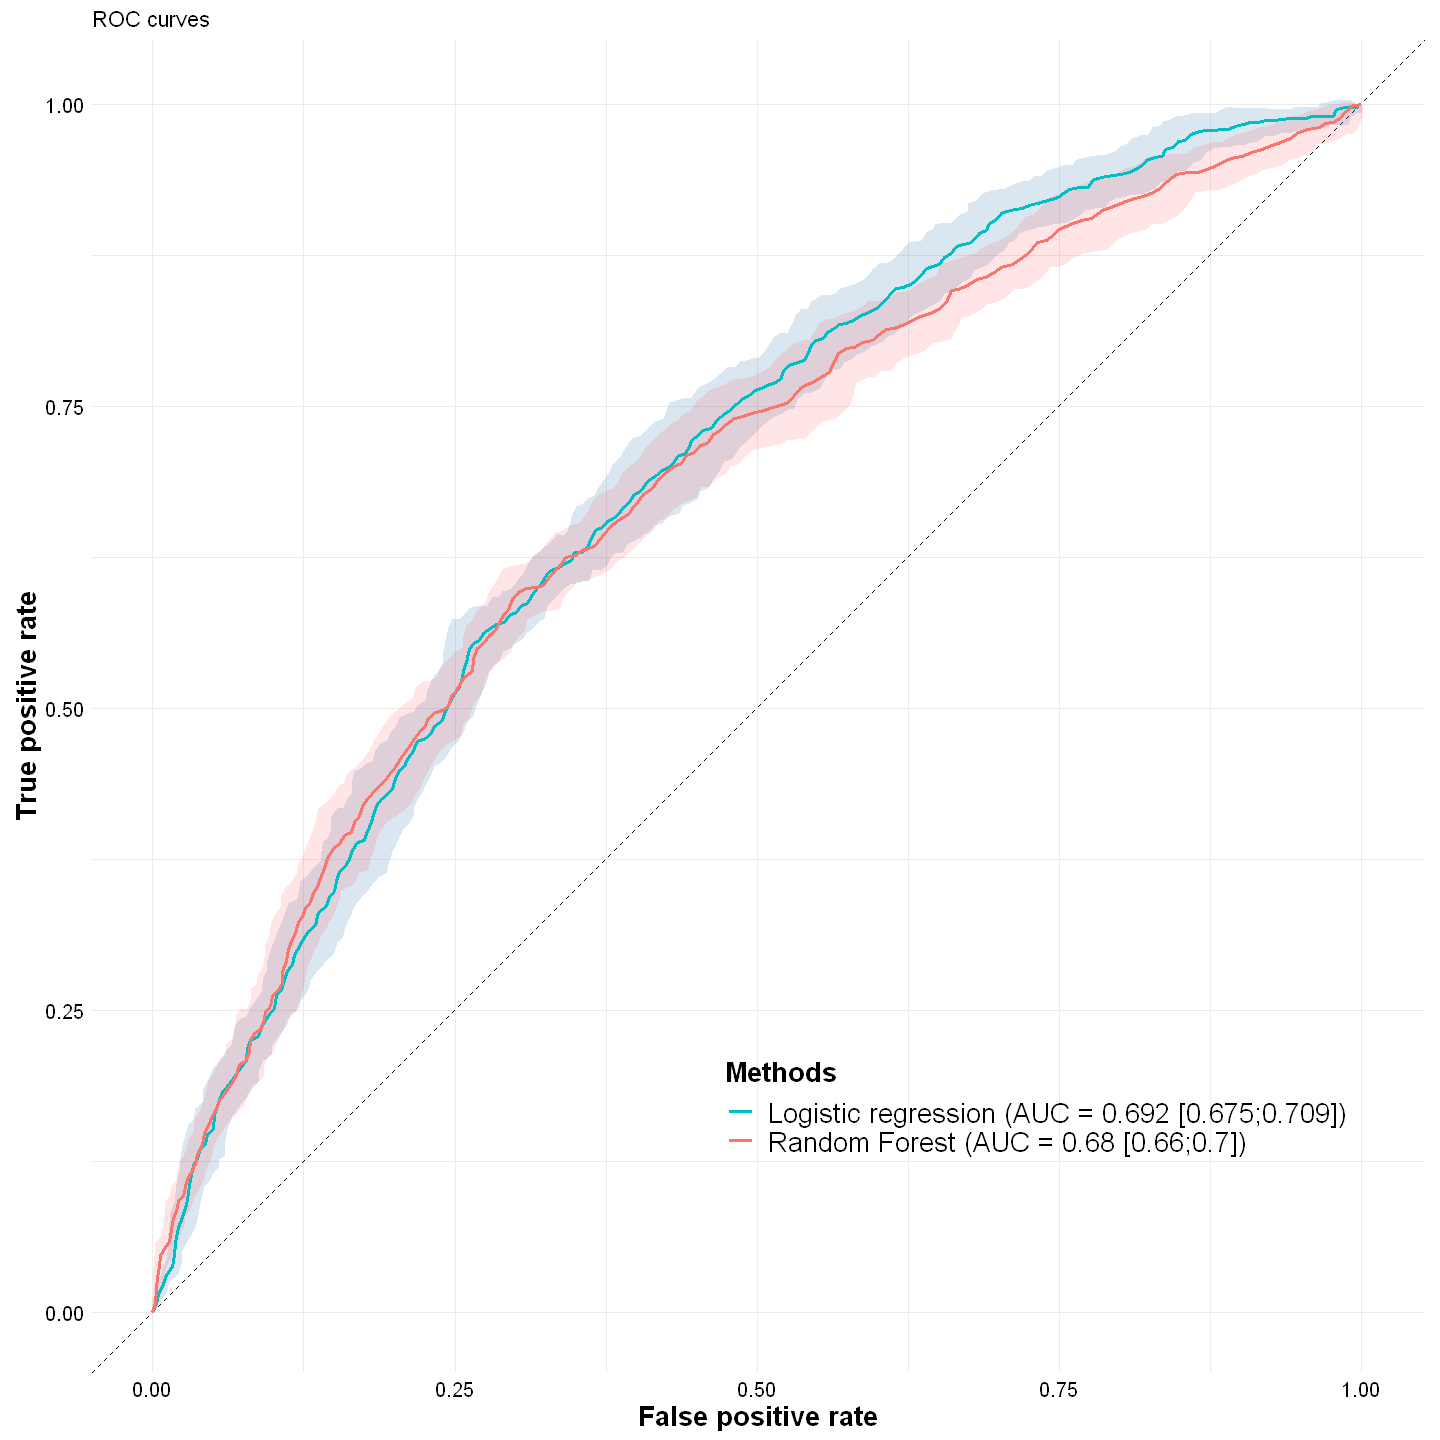

In [16]:
options(repr.plot.width = 12, repr.plot.height = 12)
ggplot() + labs(x = "False positive rate", y = "True positive rate") + 
ggtitle("ROC curves") +
geom_abline(intercept = 0, slope = 1, color = "black", linetype = "dashed") +
geom_polygon(aes(x = x_test_LR, y = y_test_LR), fill = "steelblue", alpha= 0.2) +
geom_polygon(aes(x = x_test_RF, y = y_test_RF), fill = "red", alpha= 0.1) +
geom_line(aes(x = colMeans(x_values_roc_LR), y = colMeans(y_values_roc_LR), colour = "Y"), size = 1) +
geom_line(aes(x = colMeans(x_values_roc_RF), y = colMeans(y_values_roc_RF), colour = "#CC0000"), size = 1) +
theme_minimal() + 
coord_equal() + 
theme(axis.title.x = element_text(color="black", size=16, face="bold"),
      axis.title.y = element_text(color="black", size=16, face="bold"),
      axis.text.x = element_text(color="black", size=12),
      axis.text.y = element_text(color="black", size=12)) + 
scale_colour_discrete(name = "Methods", breaks = c("Y", "#CC0000"), 
                      labels=c(paste0("Logistic regression (AUC = ", round(mean(val_auc_LR), 3), " [", 
                                      round(round(mean(val_auc_LR), 3)- 1.96*round(sd(val_auc_LR), 3)/sqrt(10),3),
                                      ";", round(round(mean(val_auc_LR), 3)+1.96*round(sd(val_auc_LR), 3)/sqrt(10),3), "])"),
                               paste0("Random Forest (AUC = ", round(mean(val_auc_RF), 3), " [", 
                                      round(round(mean(val_auc_RF), 3)- 1.96*round(sd(val_auc_RF), 3)/sqrt(10),3),
                                      ";", round(round(mean(val_auc_RF), 3)+1.96*round(sd(val_auc_RF), 3)/sqrt(10),3), "])")))+
theme(legend.position = c(0.7, 0.2)) + 
theme(legend.title = element_text(colour="black", size=16, face="bold")) + 
theme(legend.text = element_text(colour="black", size=16))


### AUC methods comparison

In [17]:
info_min <- c(min(val_auc_LR), min(val_auc_RF))
info_mean <- c(mean(val_auc_LR), mean(val_auc_RF))
info_median <- c(median(val_auc_LR), median(val_auc_RF))
info_max <- c(max(val_auc_LR), max(val_auc_RF))

In [18]:
df_info <- data.frame(info_min, info_mean, info_median, info_max, row.names = c("Logistic Regression", "Random Forest"))
colnames(df_info) <- c("Minimum", "Mean", "Median", 'Maximum')
round(df_info,3)

,Minimum,Mean,Median,Maximum
,<dbl>,<dbl>,<dbl>,<dbl>
Logistic Regression,0.64,0.692,0.70,0.72
Random Forest,0.62,0.680,0.69,0.71
